**IEA Wind TCP Task 55: The IEA Wind 740-10-MW Reference Offshore Wind Plants**

<https://www.osti.gov/biblio/2333634/>

This notebook uses `interarray` to route the collector system cables for the two wind power plants presented in the report above.

This example requires an additional package:

`pip install pyyaml-include`

In [1]:
from pathlib import Path
import numpy as np
import yaml
import yaml_include
from pyomo import environ as pyo

In [2]:
from interarray.interarraylib import L_from_site, G_from_S
from interarray.svg import svgplot
from interarray.plotting import gplot
from interarray.mesh import make_planar_embedding
from interarray.pathfinding import PathFinder
from interarray.interface import assign_cables
from interarray.MILP import pyomo as omo
from interarray.baselines.hgs import iterative_hgs_cvrp
from interarray.heuristics import EW_presolver

In [3]:
%config InlineBackend.figure_formats = ['svg']

## Load layouts from files

In [4]:
# Wind farms stored according to the windIO format
# https://windio.readthedocs.io/en/latest/

yaml.add_constructor(
    "!include", yaml_include.Constructor(base_dir='data'))

def load_windIO(filepath):
    fpath = Path(filepath)
    with open(fpath, 'r') as f:
        system = yaml.full_load(f)
    coords = (system['wind_farm']['layouts']['initial_layout']
              ['coordinates'])
    terminalC = np.c_[coords['x'], coords['y']]
    coords = system['wind_farm']['electrical_substations']['coordinates']
    rootC = np.c_[coords['x'], coords['y']]
    coords = system['site']['boundaries']['polygons'][0]
    borderC = np.c_[coords['x'], coords['y']]
    T = terminalC.shape[0]
    R = rootC.shape[0]
    name_tokens = fpath.stem.split('_')
    return L_from_site(
        R=R, T=T,
        VertexC=np.vstack((terminalC, borderC, rootC)),
        border=np.arange(T, T + borderC.shape[0]),
        name=' '.join(name_tokens),
        handle=(f'{name_tokens[0].lower()}_'
                f'{name_tokens[1][:4].lower()}_'
                f'{name_tokens[2][:3].lower()}'),
    )

In [5]:
L_reg = load_windIO('data/IEA37_Borssele_Regular_System.yaml')

In [6]:
L_irr = load_windIO('data/IEA37_Borssele_Irregular_System.yaml')

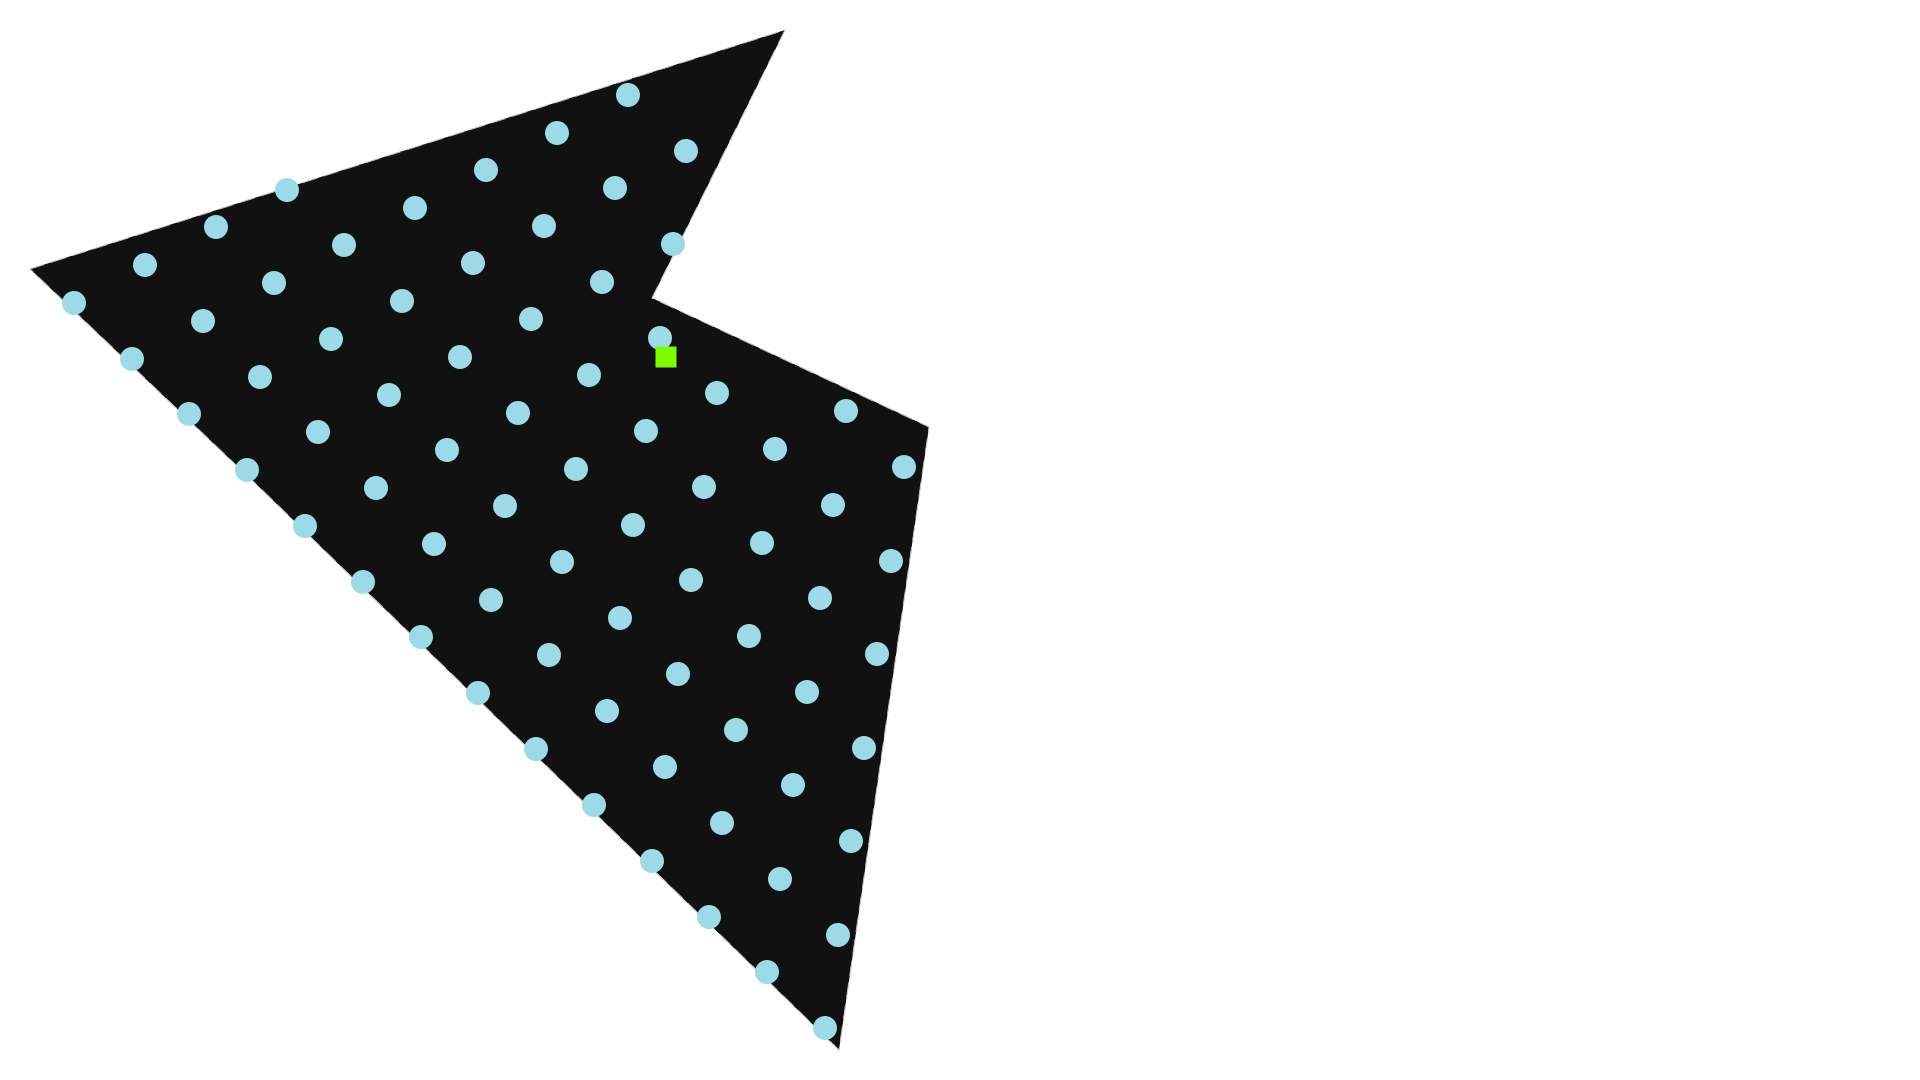

In [7]:
svgplot(L_reg)

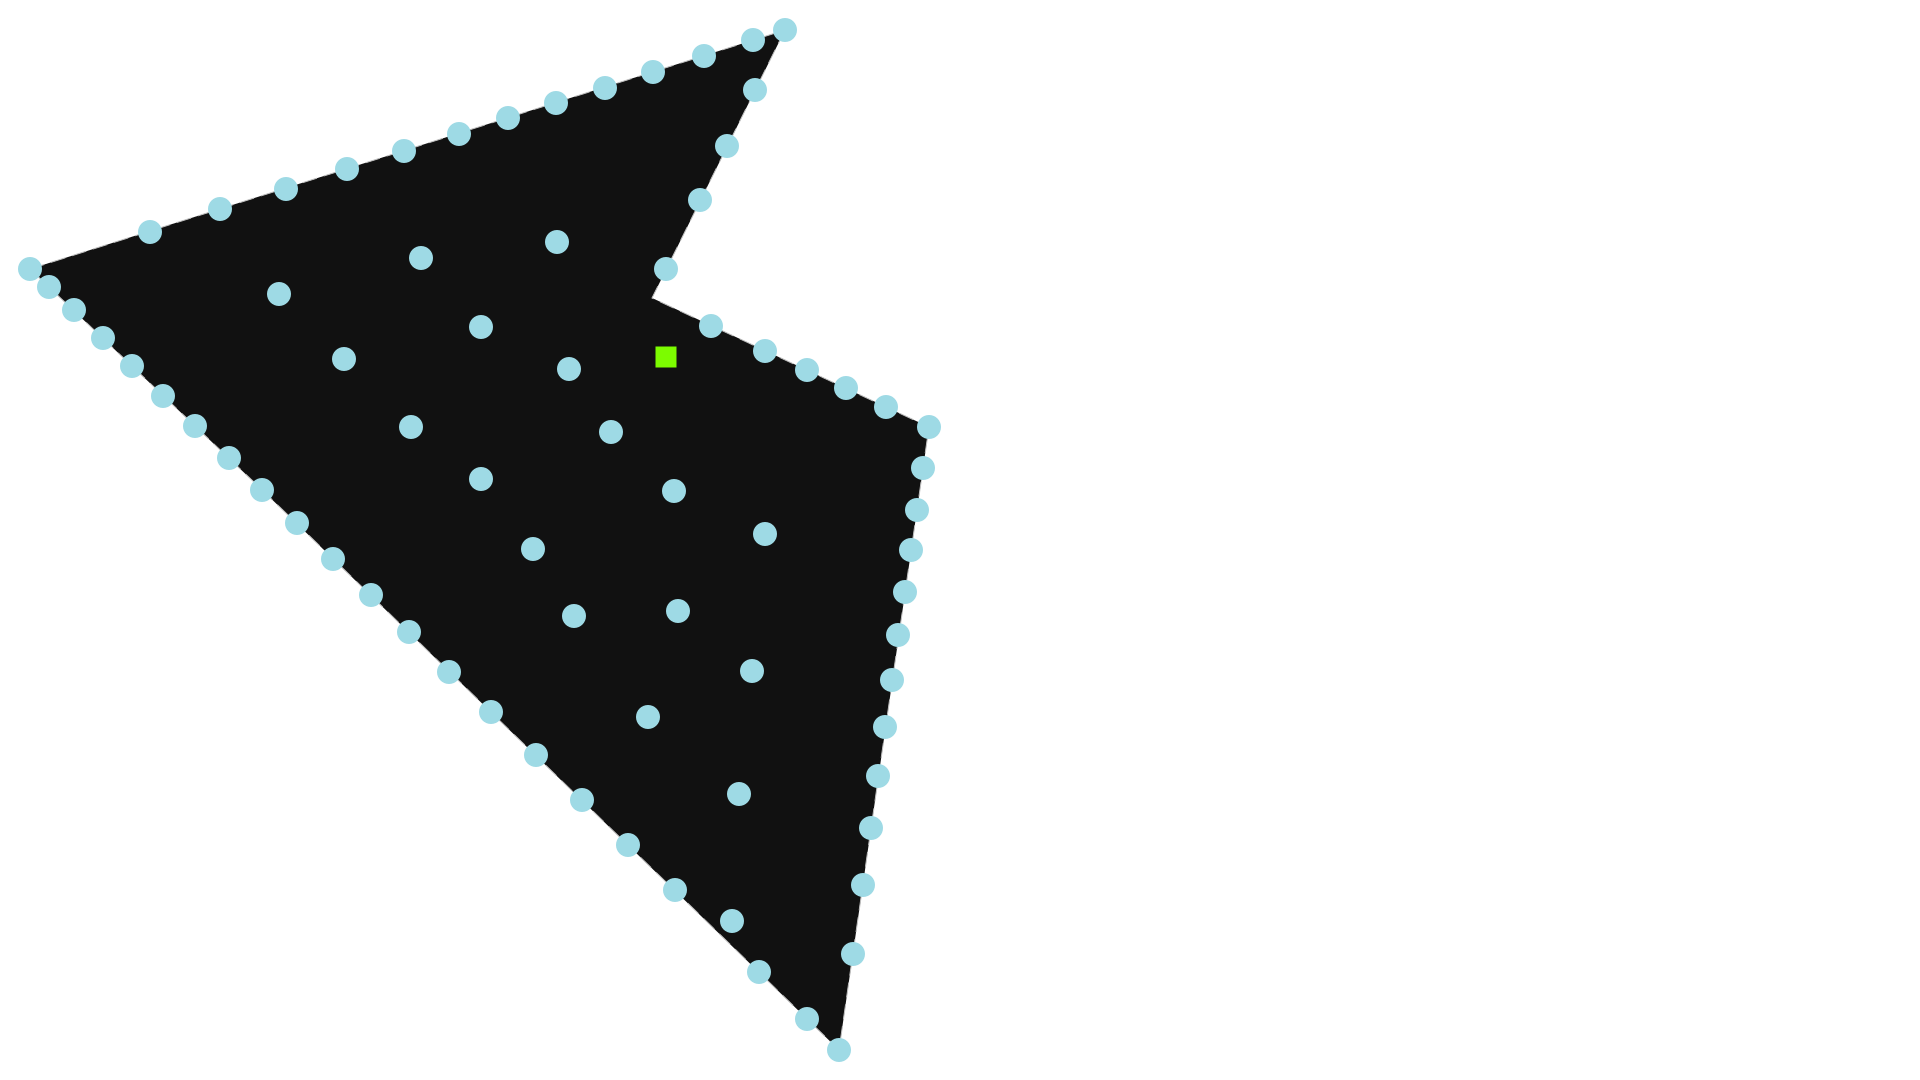

In [8]:
svgplot(L_irr)

## Additional design parameters

In [9]:
cable_costs = [206, 287, 406]  # [€/m] Costs per distance for each cable type
turbines_per_cable = [3, 5, 7]

In [10]:
cables = [(None, capacity, cost) for capacity, cost in zip(turbines_per_cable, cable_costs)]
capacity = max(turbines_per_cable)

## Choose solver

In [11]:
solver = pyo.SolverFactory('gurobi', solver_io='python')
solver.available()

True

## Regular layout

In [12]:
P, A = make_planar_embedding(L_reg)

In [13]:
# This meta-heuristic call is iterative and the time_limit applies
# to each iteration. About 97% of instances use a single iteration.
S_warm = iterative_hgs_cvrp(A, capacity=capacity, time_limit=3)

In [14]:
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(model, S_warm);

In [15]:
solver.options.update(dict(
    mipgap=0.005,  # 0.5 %
    timelimit=5,  # [s]
    mipfocus=1,  # focus on producing solutions
    threads=8,  # number of parallel threads
))
print(f'Solving "{model.name}", capacity = {model.k.value}\n')
result = solver.solve(model, tee=True, warmstart=True)

Solving "IEA37 Borssele Regular System", capacity = 7

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 5
Set parameter MIPFocus to value 1
Set parameter Threads to value 8
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  5
MIPGap  0.005
MIPFocus  1
Threads  8

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 2454 rows, 1540 columns and 8930 nonzeros
Model fingerprint: 0x9c10ddf2
Variable types: 0 continuous, 1540 integer (770 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [4e+02, 1e+04]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 7e+01]

Loaded user MIP start with objective 139656

In [16]:
S_solver = omo.S_from_solution(model, solver, result)
G_solver = G_from_S(S_solver, A)
G_reg = PathFinder(G_solver, planar=P, A=A).create_detours()

In [17]:
assign_cables(G_reg, cables)
G_reg.size(weight='cost')

40711761.53062653

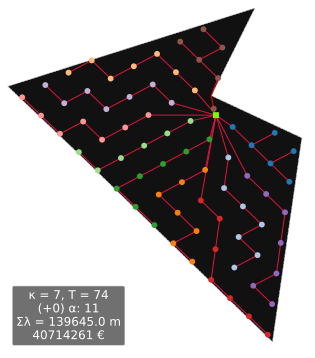

In [18]:
gplot(G_reg, node_tag=None);

In [19]:
# Here a heuristic is used to warm-start the solver
S_warm = EW_presolver(A, capacity=capacity)

In [20]:
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(model, S_warm);

If the solver is given more time (~9 min) and a focus on tightening the bound, a better solution is achieved:

In [21]:
solver.options.update(dict(
    mipgap=0.002,  # 0.5 %
    timelimit=1200,  # [s]
    mipfocus=3,
    threads=16,  # number of parallel threads
))
print(f'Solving "{model.name}", capacity = {model.k.value}\n')
result = solver.solve(model, tee=True, warmstart=True)

Solving "IEA37 Borssele Regular System", capacity = 7

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.002
Set parameter TimeLimit to value 1200
Set parameter MIPFocus to value 3
Set parameter Threads to value 16
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  1200
MIPGap  0.002
MIPFocus  3
Threads  16

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 2454 rows, 1540 columns and 8930 nonzeros
Model fingerprint: 0x780878e9
Variable types: 0 continuous, 1540 integer (770 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [4e+02, 1e+04]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 7e+01]

Loaded user MIP start with objecti

In [22]:
S_solver = omo.S_from_solution(model, solver, result)
G_solver = G_from_S(S_solver, A)
G_reg = PathFinder(G_solver, planar=P, A=A).create_detours()

In [23]:
assign_cables(G_reg, cables)
G_reg.size(weight='cost')

40711761.53062653

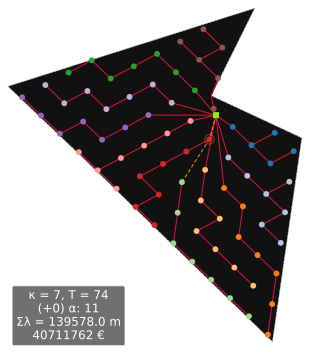

In [24]:
gplot(G_reg, node_tag=None);

## Irregular layout

In [25]:
P, A = make_planar_embedding(L_irr)

In [26]:
# This meta-heuristic call is iterative and the time_limit applies
# to each iteration. About 97% of instances use a single iteration.
S_warm = iterative_hgs_cvrp(A, capacity=capacity, time_limit=3)

In [27]:
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(model, S_warm);

In [28]:
solver.options.update(dict(
    mipgap=0.005,  # 0.5 %
    timelimit=5,  # [s]
    mipfocus=1,  # focus on producing solutions
    threads=8,  # number of parallel threads
))
print(f'Solving "{model.name}", capacity = {model.k.value}\n')
result = solver.solve(model, tee=True, warmstart=True)

Solving "IEA37 Borssele Irregular System", capacity = 7

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 5
Set parameter MIPFocus to value 1
Set parameter Threads to value 8
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  5
MIPGap  0.005
MIPFocus  1
Threads  8

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 1910 rows, 1192 columns and 6654 nonzeros
Model fingerprint: 0x3bc6a85c
Variable types: 0 continuous, 1192 integer (596 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [5e+02, 2e+04]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 7e+01]

Loaded user MIP start with objective 1364

In [29]:
S_solver = omo.S_from_solution(model, solver, result)
G_solver = G_from_S(S_solver, A)
G_irr = PathFinder(G_solver, planar=P, A=A).create_detours()

In [30]:
assign_cables(G_irr, cables)
G_irr.size(weight='cost')

43091183.191651106

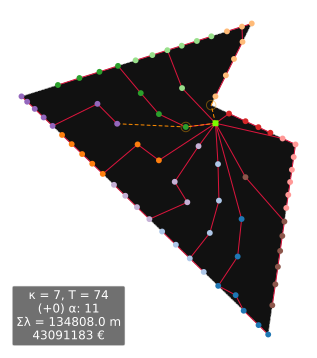

In [31]:
gplot(G_irr, node_tag=None);

## Layouts' edge list

These lists of 3-tuples has all the edges and their cable type (as an index to the `turbines_per_cable` list), i.e. (coordinate_A, coordinate_B, cable_type).

Negative node indices represent substations, the node indices ranging from 0 to 73 represent the WT in the order they were given.

If the layout has contours or detours, indices will go beyond the number of coordinates (WT, SS, borders) provided, and the mapping of these additional indices to indices to the provided coordinates is presented.

In [32]:
G_reg.edges(data='cable')

EdgeDataView([(-1, 47, 2), (-1, 56, 2), (-1, 46, 2), (-1, 57, 2), (-1, 33, 2), (-1, 45, 1), (-1, 34, 2), (-1, 49, 2), (-1, 23, 2), (-1, 58, 2), (-1, 81, 2), (45, 44, 1), (33, 32, 2), (23, 22, 2), (34, 24, 2), (57, 67, 2), (25, 17, 2), (25, 81, 2), (46, 35, 2), (47, 48, 2), (49, 50, 2), (58, 59, 2), (56, 80, 1), (44, 31, 0), (44, 43, 0), (18, 19, 0), (19, 26, 0), (26, 27, 0), (27, 36, 1), (31, 42, 0), (32, 21, 1), (63, 70, 0), (70, 61, 0), (61, 69, 0), (69, 68, 1), (5, 4, 0), (5, 10, 0), (10, 11, 1), (4, 1, 0), (11, 17, 1), (51, 62, 0), (51, 60, 1), (60, 59, 1), (53, 62, 0), (53, 64, 0), (8, 9, 0), (8, 3, 0), (9, 16, 0), (16, 15, 1), (41, 52, 0), (41, 54, 0), (52, 39, 1), (14, 7, 1), (14, 22, 1), (7, 6, 0), (39, 50, 1), (24, 15, 1), (2, 0, 0), (2, 6, 0), (35, 36, 1), (37, 48, 1), (37, 38, 1), (12, 13, 0), (13, 20, 0), (29, 38, 0), (29, 28, 0), (29, 40, 0), (20, 21, 0), (21, 30, 0), (72, 71, 0), (71, 66, 0), (73, 66, 0), (66, 65, 1), (68, 67, 1), (65, 80, 1), (54, 55, 0)])

Mapping of contour/detour node to the index of its VertexC coordinate :

In [33]:
if G_reg.graph.get('C') or G_reg.graph.get('D'):
    R, T, B = (G_reg.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in G_reg.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 76, 81: 46}


In [34]:
G_irr.edges(data='cable')

EdgeDataView([(-1, 41, 2), (-1, 28, 2), (-1, 49, 2), (-1, 55, 1), (-1, 39, 2), (-1, 60, 2), (-1, 70, 2), (-1, 25, 2), (-1, 33, 2), (-1, 80, 2), (-1, 81, 2), (70, 67, 2), (41, 51, 2), (49, 54, 2), (71, 64, 2), (71, 81, 2), (28, 53, 2), (60, 59, 2), (55, 40, 0), (25, 42, 2), (73, 68, 2), (73, 80, 2), (39, 63, 2), (33, 45, 2), (58, 65, 0), (58, 61, 1), (61, 64, 1), (48, 65, 0), (65, 47, 0), (16, 29, 1), (16, 17, 0), (29, 53, 1), (36, 62, 0), (36, 35, 0), (62, 69, 1), (35, 6, 0), (69, 63, 1), (8, 42, 1), (8, 2, 1), (37, 51, 1), (37, 20, 1), (20, 4, 0), (20, 34, 0), (67, 22, 1), (5, 9, 0), (5, 32, 0), (32, 14, 1), (10, 24, 0), (24, 17, 0), (40, 57, 0), (1, 34, 0), (22, 44, 1), (23, 43, 0), (43, 7, 0), (31, 26, 0), (31, 56, 0), (56, 30, 1), (26, 13, 0), (14, 68, 1), (27, 52, 0), (27, 38, 0), (52, 59, 0), (59, 18, 0), (3, 12, 1), (3, 15, 0), (12, 45, 1), (0, 50, 0), (50, 46, 0), (11, 18, 0), (2, 7, 0), (30, 54, 1), (21, 15, 0), (21, 66, 0), (9, 19, 0), (57, 72, 0), (46, 44, 0)])

Mapping of contour/detour node to the index of its VertexC coordinate :

In [35]:
if G_irr.graph.get('C') or G_irr.graph.get('D'):
    R, T, B = (G_irr.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in G_irr.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 28, 81: 76}
